| Name | Surname | ID Number |
|------|---------|---------------------|
| Lorenzo | Calandra Buonaura | 2107761 |

In [1]:
library("ggplot2", warn.conflicts = FALSE, quietly = TRUE)
library("spatstat", warn.conflicts = FALSE, quietly = TRUE)
library("Hmisc", warn.conflicts = FALSE, quietly = TRUE)
library("cmdstanr")
library("gridExtra")

spatstat.geom 3.2-9

spatstat.random 3.2-3

spatstat.explore 3.2-7

spatstat.model 3.2-11

spatstat.linnet 3.1-5


spatstat 3.0-8 
For an introduction to spatstat, type ‘beginner’ 


This is cmdstanr version 0.8.0

- CmdStanR documentation and vignettes: mc-stan.org/cmdstanr

- CmdStan path: /home/kallo27/anaconda3/bin/cmdstan

- CmdStan version: 2.31.0


A newer version of CmdStan is available. See ?install_cmdstan() to install it.
To disable this check set option or environment variable cmdstanr_no_ver_check=TRUE.



# Exercise 1

Ladislaus Josephovich Bortkiewicz was a Russian economist and statistician. He noted that the Poisson distribution can be very useful in applied statistics when describing low-frequency events in a large population. In a famous example he showed that the number of deaths by horse kick among the Prussian army follows the Poisson distribution.

Considering the following two sets of observations taken over a fixed large time interval in two different corps:

| y - death soldiers |  0  | 1  | 2  | 3  | 4 | ≥5 |
|--------------------|-----|----|----|----|---|----|
| n1 - observations  | 109 | 65 | 22 | 3  | 1 | 0  |
| n2 - observations  | 144 | 91 | 32 | 11 | 2 | 0  |

(a) assuming a uniform prior, compute and plot the posterior distribution for $\lambda$, the death rate over the measurement time. Determine the posterior mean, median and variance, and compute the 95% credibility interval.

In [14]:
c_int <- function(val, int, param) {
  low <- 0
  up <- 0
  a <- 1
  b <- 1

  limits <- c((1 - int) / 2, (1 + int) / 2)

  while (low < limits[1]) {
    low <- low + val[a]
    a <- a + 1
  }

  while (up < limits[2]) {
    up <- up + val[b]
    b <- b + 1
  }

  if (b > length(param)) {
    b <- length(param)
  }

  return(c(param[a], param[b]))
}

In [10]:
y <- c(0, 1, 2, 3, 4, ">=5")
n1 <- c(109, 65, 22, 3, 1, 0)
n2 <- c(144, 91, 32, 11, 2, 0)

combined_obs <- n1 + n2

total_counts <- sum(combined_obs)
total_deaths <- sum(c(0, 1, 2, 3, 4, 5) * combined_obs)

Mean: 0.6645833 
Median: 0.6635 
Variance: 0.001395138 
95% Credibility Interval: ( 0.595 , 0.74 )


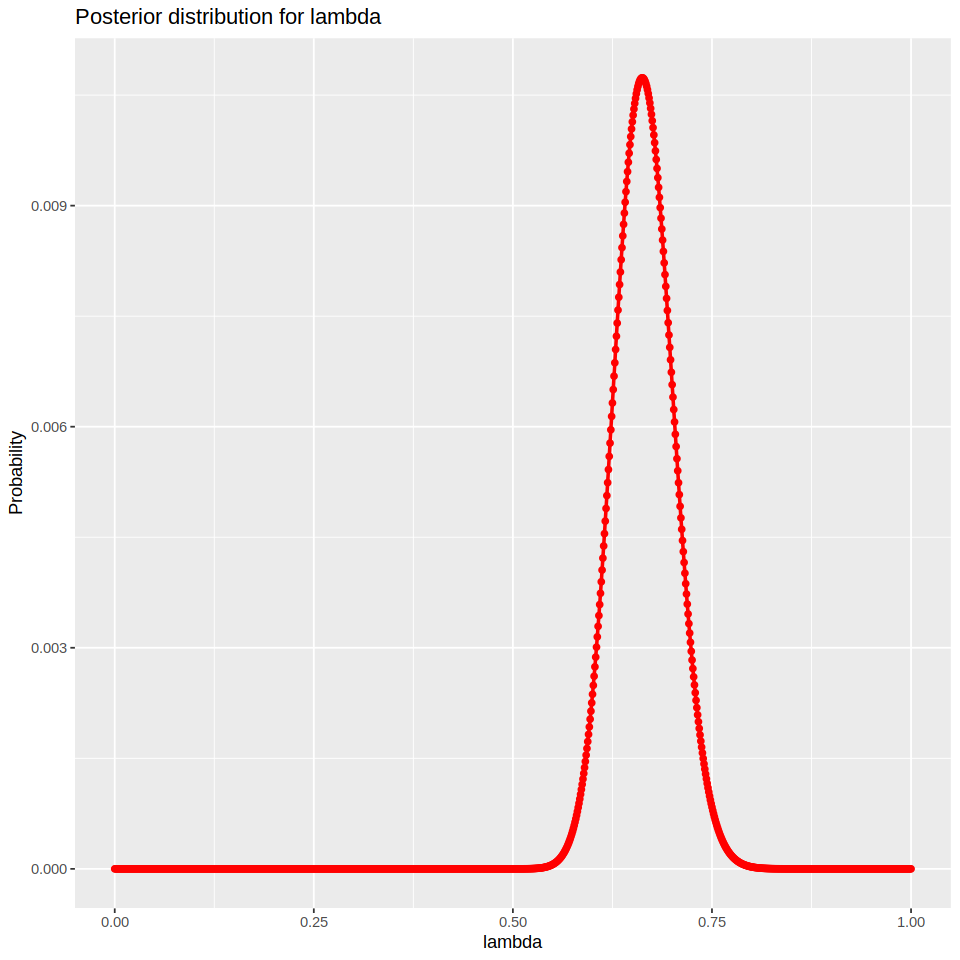

In [16]:
lambda <- seq(0, 1, 0.001)
post_values <- dgamma(lambda, shape = total_deaths + 1, rate = total_counts)
post_values <- post_values / sum(post_values)

options(repr.plot.width = 8, repr.plot.height = 8)

ggplot(data = data.frame(lambda, post_values),
       aes(x = lambda, y = post_values)) +
  geom_point(color = "red", size = 1.5) +
  geom_line(color = "red", linewidth = 1) +
  labs(title = "Posterior distribution for lambda",
       x = "lambda",
       y = "Probability")

lambda_mean <- weighted.mean(lambda, post_values)
lambda_median <- weighted.median(lambda, post_values)
lambda_variance <- weighted.var(lambda, post_values)

cred_int <- c_int(post_values, 0.95, lambda)

cat("Mean:", lambda_mean, "\n")
cat("Median:", lambda_median, "\n")
cat("Variance:", lambda_variance, "\n")
cat("95% Credibility Interval:", "(", cred_int[1], ",", cred_int[2], ")\n")

(b) assuming now a Jeffreys’ prior, $g(\lambda) \propto \frac{1}{\sqrt{\lambda}}$, with $\lambda > 0$, compute and plot the posterior distribution for λ, the death rate over the measurement time. Determine the posterior mean, median and variance, and compute the 95% credibility interval

Mean: 0.6635417 
Median: 0.6625 
Variance: 0.00139296 
95% Credibility Interval: ( 0.594 , 0.739 )


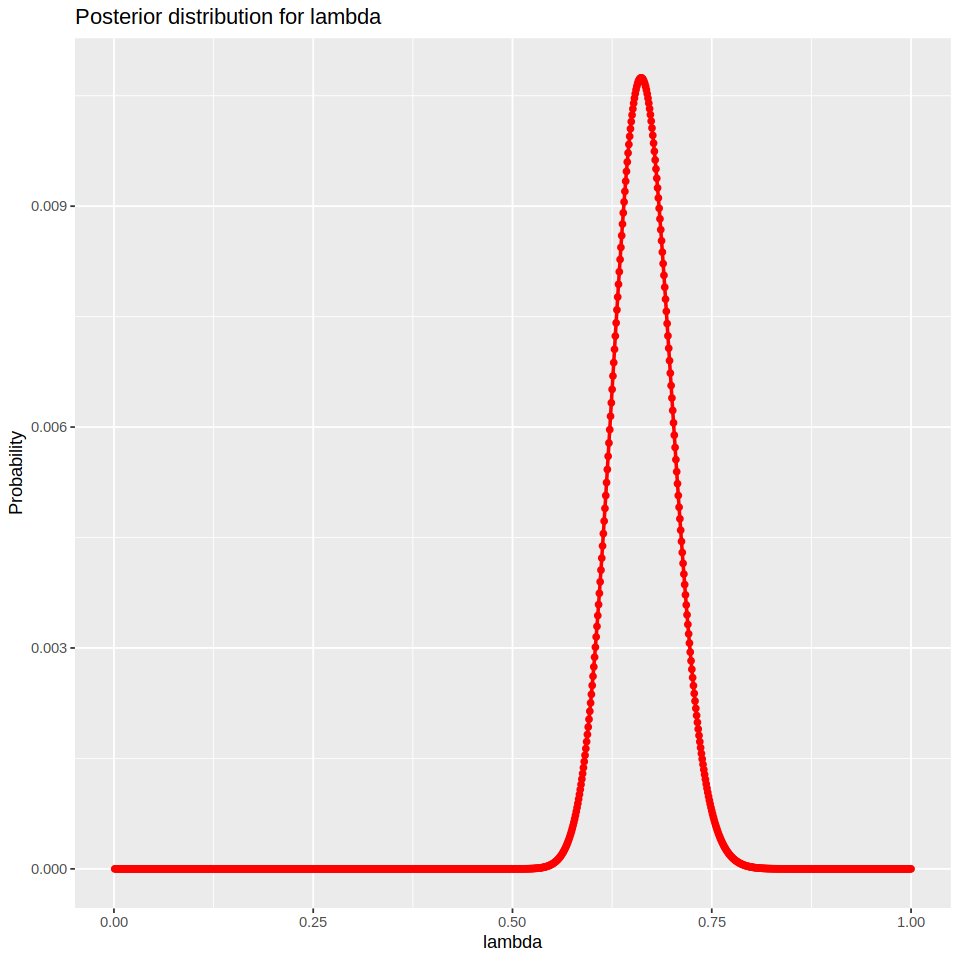

In [17]:
prior <- function(lambda) {
  return(1 / sqrt(lambda))
}

lambda <- seq(0.001, 1, 0.001)
prior_values <- prior(lambda)
post_values <- dgamma(lambda, shape = total_deaths + 1, rate = total_counts)
post_values <- post_values * prior_values / sum(post_values * prior_values)

options(repr.plot.width = 8, repr.plot.height = 8)

ggplot(data = data.frame(lambda, post_values),
       aes(x = lambda, y = post_values)) +
  geom_point(color = "red", size = 1.5) +
  geom_line(color = "red", linewidth = 1) +
  labs(title = "Posterior distribution for lambda",
       x = "lambda",
       y = "Probability")

lambda_mean <- weighted.mean(lambda, post_values)
lambda_median <- weighted.median(lambda, post_values)
lambda_variance <- weighted.var(lambda, post_values)

cred_int <- c_int(post_values, 0.95, lambda)

cat("Mean:", lambda_mean, "\n")
cat("Median:", lambda_median, "\n")
cat("Variance:", lambda_variance, "\n")
cat("95% Credibility Interval:", "(", cred_int[1], ",", cred_int[2], ")\n")

# Exercise 2

Solve Exercise 1 using a Markov Chain Monte Carlo using **stan**.

In [11]:
occurrencies <- rep(0:5, combined_obs)
data_list <- list(y = occurrencies, N = length(occurrencies))

In [2]:
model_string_uniform <- "data {
  int<lower=0> N;
  array[N] int y;
}
parameters {
  real<lower=0, upper=1> lambda;
}
model {
  lambda ~ beta(1, 1);
  y ~ poisson(lambda);
}"

writeLines(model_string_uniform, "model_string_uniform.stan")

In [3]:
mod <- cmdstan_model("model_string_uniform.stan")

In [12]:
fit <- mod$sample(
  data = data_list,
  seed = 123,
  chains = 4,
  parallel_chains = 4,
  refresh = 500,
  iter_warmup = 1000,
  iter_sampling = 1000
)

fit$summary()

Running MCMC with 4 parallel chains...

Chain 1 Iteration:    1 / 2000 [  0%]  (Warmup) 
Chain 1 Iteration:  500 / 2000 [ 25%]  (Warmup) 
Chain 1 Iteration: 1000 / 2000 [ 50%]  (Warmup) 
Chain 1 Iteration: 1001 / 2000 [ 50%]  (Sampling) 
Chain 1 Iteration: 1500 / 2000 [ 75%]  (Sampling) 
Chain 1 Iteration: 2000 / 2000 [100%]  (Sampling) 
Chain 2 Iteration:    1 / 2000 [  0%]  (Warmup) 
Chain 2 Iteration:  500 / 2000 [ 25%]  (Warmup) 
Chain 2 Iteration: 1000 / 2000 [ 50%]  (Warmup) 
Chain 2 Iteration: 1001 / 2000 [ 50%]  (Sampling) 
Chain 2 Iteration: 1500 / 2000 [ 75%]  (Sampling) 
Chain 2 Iteration: 2000 / 2000 [100%]  (Sampling) 
Chain 3 Iteration:    1 / 2000 [  0%]  (Warmup) 
Chain 3 Iteration:  500 / 2000 [ 25%]  (Warmup) 
Chain 3 Iteration: 1000 / 2000 [ 50%]  (Warmup) 
Chain 3 Iteration: 1001 / 2000 [ 50%]  (Sampling) 
Chain 3 Iteration: 1500 / 2000 [ 75%]  (Sampling) 
Chain 3 Iteration: 2000 / 2000 [100%]  (Sampling) 
Chain 4 Iteration:    1 / 2000 [  0%]  (Warmup) 
Chain 4 Ite

variable,mean,median,sd,mad,q5,q95,rhat,ess_bulk,ess_tail
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
lp__,-450.9503155,-450.673000,0.74891490,0.33358500,-452.3832500,-450.4300000,1.000889,1698.756,1778.112
lambda,0.6639973,0.662937,0.03761897,0.03779073,0.6038882,0.7266127,1.000827,1239.759,1604.171


In [13]:
posterior_samples <- fit$draws(variables = "lambda")
lambda_samples_uniform <- as.vector(as.matrix(posterior_samples))

lambda_mean <- mean(posterior_samples)
lambda_median <- median(posterior_samples)
lambda_variance <- var(posterior_samples)
cred_interval_unif <- quantile(posterior_samples, probs = c(0.025, 0.975))

cat("Mean:", lambda_mean, "\n")
cat("Median:", lambda_median, "\n")
cat("Variance:", lambda_variance, "\n")
cat("95% Credibility Interval:", cred_interval_unif, "\n")

Mean: 0.6639973 
Median: 0.662937 
Variance: 0.001415187 
95% Credibility Interval: 0.5922939 0.7385467 


In [4]:
model_string_jeffrey <- "data {
  int<lower=0> N;
  array[N] int y;
}
parameters {
  real<lower=0, upper=1> lambda;
}
model {
  lambda ~ gamma(0.5, 0.5); // Jeffrey's prior: gamma(0.5, 0.5)
  target += -log(lambda);   // Adding the log of Jacobian adjustment
  y ~ poisson(lambda);
}"

writeLines(model_string_jeffrey, "model_string_jeffrey.stan")

In [5]:
mod2 <- cmdstan_model("model_string_jeffrey.stan")

In [14]:
fit <- mod2$sample(
  data = data_list,
  seed = 123,
  chains = 4,
  parallel_chains = 4,
  refresh = 500,
  iter_warmup = 1000,
  iter_sampling = 1000
)

fit$summary()

Running MCMC with 4 parallel chains...

Chain 1 Iteration:    1 / 2000 [  0%]  (Warmup) 
Chain 1 Iteration:  500 / 2000 [ 25%]  (Warmup) 
Chain 1 Iteration: 1000 / 2000 [ 50%]  (Warmup) 
Chain 1 Iteration: 1001 / 2000 [ 50%]  (Sampling) 
Chain 1 Iteration: 1500 / 2000 [ 75%]  (Sampling) 
Chain 1 Iteration: 2000 / 2000 [100%]  (Sampling) 
Chain 2 Iteration:    1 / 2000 [  0%]  (Warmup) 
Chain 2 Iteration:  500 / 2000 [ 25%]  (Warmup) 
Chain 2 Iteration: 1000 / 2000 [ 50%]  (Warmup) 
Chain 2 Iteration: 1001 / 2000 [ 50%]  (Sampling) 
Chain 2 Iteration: 1500 / 2000 [ 75%]  (Sampling) 
Chain 2 Iteration: 2000 / 2000 [100%]  (Sampling) 
Chain 3 Iteration:    1 / 2000 [  0%]  (Warmup) 
Chain 3 Iteration:  500 / 2000 [ 25%]  (Warmup) 
Chain 3 Iteration: 1000 / 2000 [ 50%]  (Warmup) 
Chain 3 Iteration: 1001 / 2000 [ 50%]  (Sampling) 
Chain 3 Iteration: 1500 / 2000 [ 75%]  (Sampling) 
Chain 3 Iteration: 2000 / 2000 [100%]  (Sampling) 
Chain 4 Iteration:    1 / 2000 [  0%]  (Warmup) 
Chain 4 Ite

variable,mean,median,sd,mad,q5,q95,rhat,ess_bulk,ess_tail
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
lp__,-450.6641798,-450.3790000,0.74375718,0.33506760,-452.1721000,-450.1330000,1.004271,1559.135,2001.764
lambda,0.6608715,0.6598595,0.03784868,0.03802054,0.5995052,0.7242576,1.003382,1197.348,1272.478


In [15]:
posterior_samples <- fit$draws(variables = "lambda")
lambda_samples_jeffrey <- as.vector(as.matrix(posterior_samples))

lambda_mean <- mean(posterior_samples)
lambda_median <- median(posterior_samples)
lambda_variance <- var(posterior_samples)
cred_interval_jeff <- quantile(posterior_samples, probs = c(0.025, 0.975))

cat("Mean:", lambda_mean, "\n")
cat("Median:", lambda_median, "\n")
cat("Variance:", lambda_variance, "\n")
cat("95% Credibility Interval:", cred_interval_jeff, "\n")

Mean: 0.6608715 
Median: 0.6598595 
Variance: 0.001432523 
95% Credibility Interval: 0.5889337 0.737879 


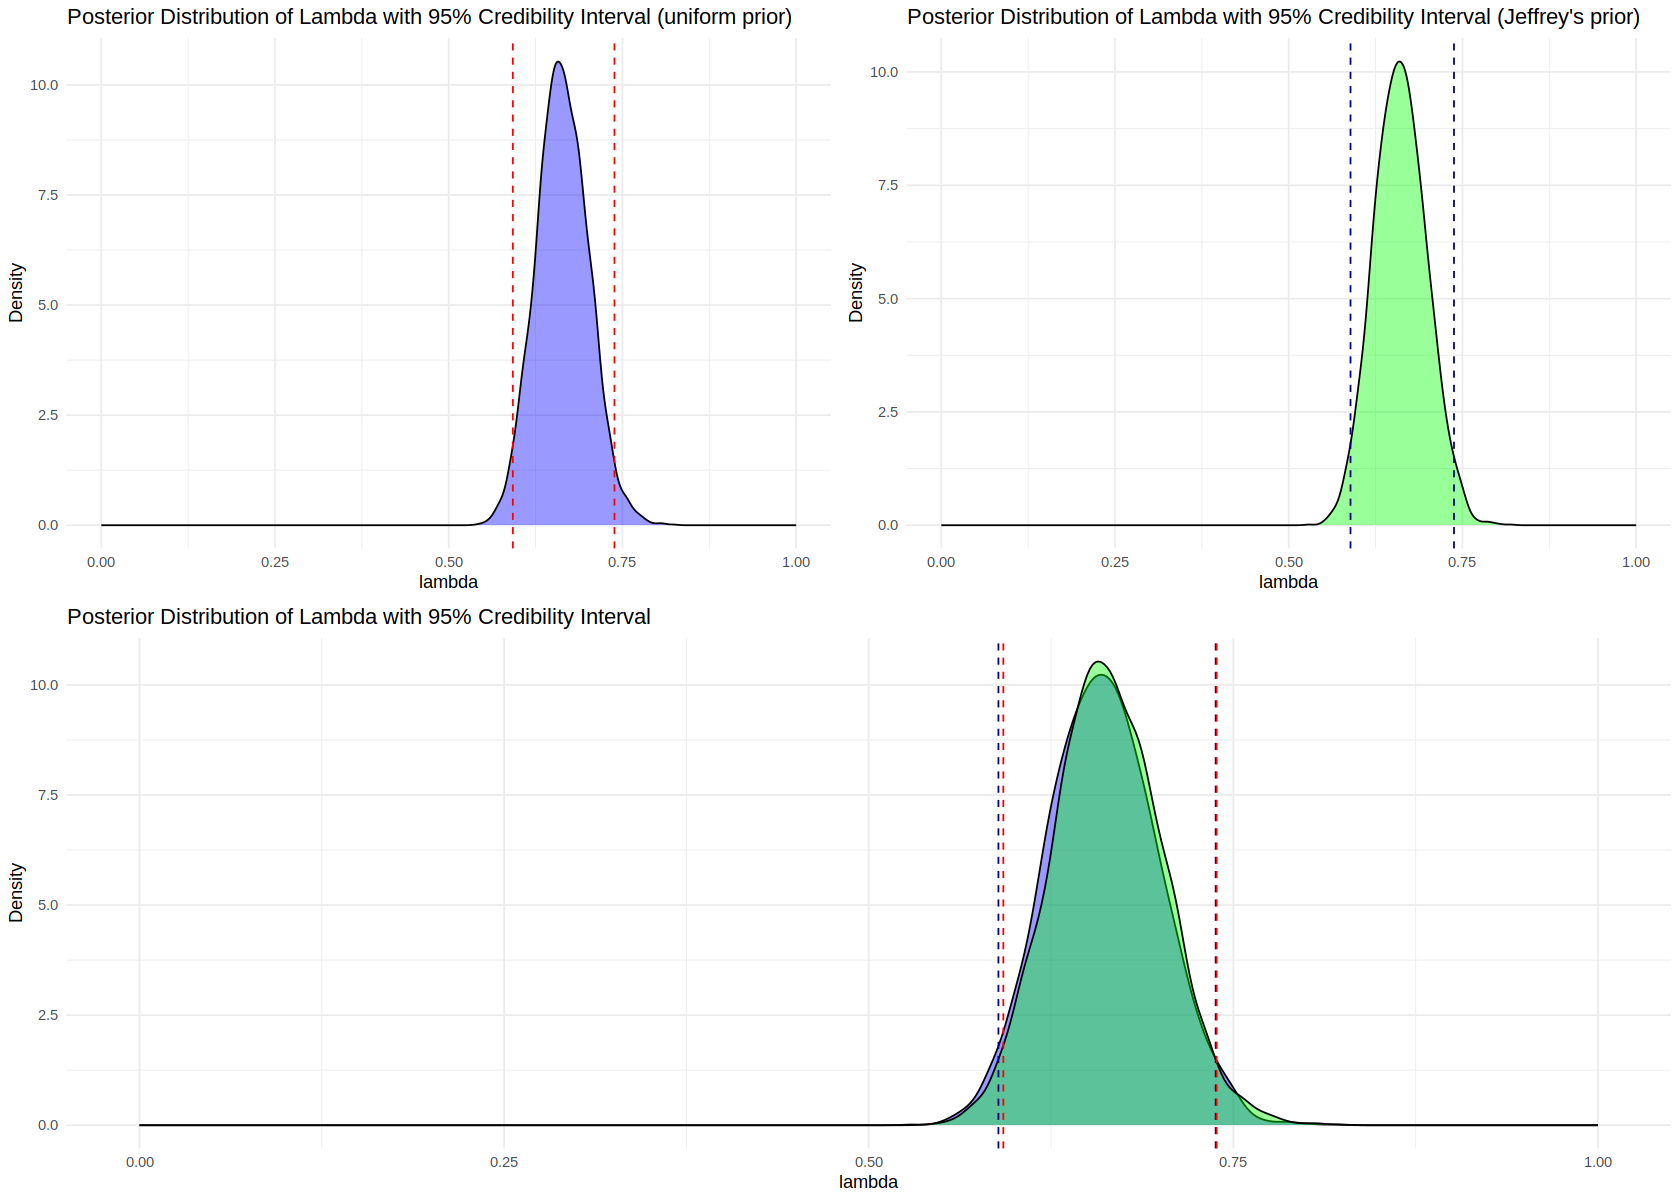

In [16]:
df_jeffrey <- data.frame(lambda = lambda_samples_jeffrey)
df_uniform <- data.frame(lambda = lambda_samples_uniform)

unif_plot <- ggplot() +
  geom_density(data = df_uniform, aes(x = lambda), fill = "blue", alpha = 0.4) +
  geom_vline(xintercept = cred_interval_unif[1],
             linetype = "dashed", color = "red") +
  geom_vline(xintercept = cred_interval_unif[2],
             linetype = "dashed", color = "red") +
  labs(title = "Posterior Distribution of Lambda with 95% Credibility Interval (uniform prior)", # nolinter
       x = "lambda", y = "Density") +
  xlim(0, 1) +
  theme_minimal()

jeff_plot <- ggplot() +
  geom_density(data = df_jeffrey, aes(x = lambda), fill = "green", alpha = .4) +
  geom_vline(xintercept = cred_interval_jeff[1],
             linetype = "dashed", color = "navy") +
  geom_vline(xintercept = cred_interval_jeff[2],
             linetype = "dashed", color = "navy") +
  labs(title = "Posterior Distribution of Lambda with 95% Credibility Interval (Jeffrey's prior)", # nolinter
       x = "lambda", y = "Density") +
  xlim(0, 1) +
  theme_minimal()

combined_plot <- ggplot() +
  geom_density(data = df_jeffrey, aes(x = lambda), fill = "blue", alpha = 0.4) +
  geom_density(data = df_uniform, aes(x = lambda), fill = "green", alpha = .4) +
  geom_vline(xintercept = cred_interval_jeff[1],
             linetype = "dashed", color = "navy") +
  geom_vline(xintercept = cred_interval_jeff[2],
             linetype = "dashed", color = "navy") +
  geom_vline(xintercept = cred_interval_unif[1],
             linetype = "dashed", color = "red") +
  geom_vline(xintercept = cred_interval_unif[2],
             linetype = "dashed", color = "red") +
  labs(title = "Posterior Distribution of Lambda with 95% Credibility Interval",
       x = "lambda", y = "Density") +
  xlim(0, 1) +
  theme_minimal()

options(repr.plot.width = 14, repr.plot.height = 10)
grid.arrange(unif_plot, jeff_plot, combined_plot,
             layout_matrix = rbind(c(1, 2), c(3, 3)))

# Exercise 3 

A study on water quality of streams, a high level of bacter X was defined as a level greater than 100 per 100 ml of stream water. $n = 116$ samples were taken from streams having a high environmental impact on pandas. Out of these, $y = 11$ had a high bacter X level.

Indicating with $p$ the probability that a sample of water taken from the stream has a high bacter X level:

(a) find the frequentist estimator for $p$

In [ ]:
n <- 116
y <- 11

frequentist_estimator <- y / n

cat("Frequentist estimator for the probability that a sample of water taken from the stream has a high bacter X level:", # nolinter
    frequentist_estimator)

Frequentist estimator for the probability that a sample of water taken from the stream has a high bacter X level: 0.09482759

(b) using a Beta(1,10) prior for $p$, calculate and plot the posterior distribution $P(p|y)$

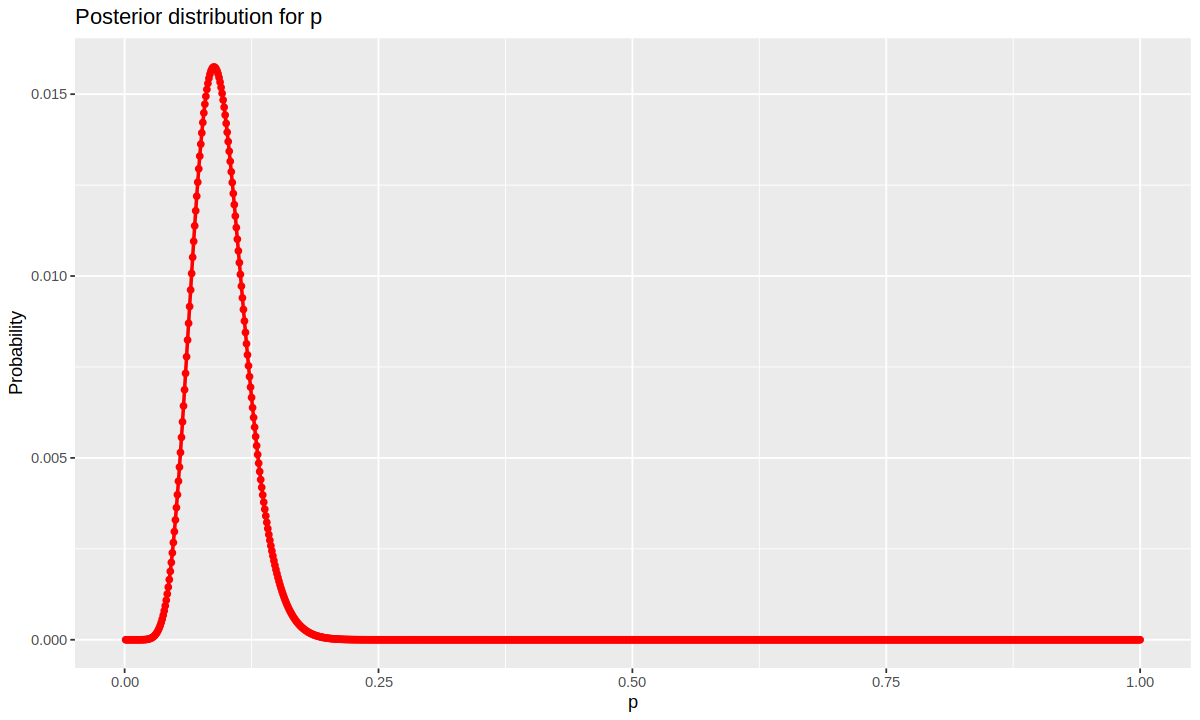

In [ ]:
post_beta <- function(r, n, params, p) {
  beta <- dbeta(p, params[1], params[2])
  normalization <- sum(beta * dbinom(r, n, p))

  return(beta * dbinom(r, n, p) / normalization)
}

p <- seq(0.001, 1, 0.001)
post_beta_values <- post_beta(y, n, c(1, 10), p)

ggplot(data = data.frame(p, post_beta_values),
       aes(x = p, y = post_beta_values)) +
  geom_point(color = "red", size = 1.5) +
  geom_line(color = "red", linewidth = 1) +
  labs(title = "Posterior distribution for p",
       x = "p",
       y = "Probability")

(c) find the bayesian estimator for $p$, the posterior mean and variance, and a 95% credible interval

In [ ]:
p_mean <- weighted.mean(p, post_beta_values)
p_median <- weighted.median(p, post_beta_values)
p_variance <- weighted.var(p, post_beta_values)

cred_int <- c_int(post_beta_values, 0.95, p)

cat("Mean:", p_mean, "\n")
cat("Median:", p_median, "\n")
cat("Variance:", p_variance, "\n")
cat("95% Credibility Interval:", "(", cred_int[1], ",", cred_int[2], ")\n")
cat("\nIn general, the mean is taken as the bayesian estimator:", p_mean, "\n")

Mean: 0.09448819 
Median: 0.0915 
Variance: 0.000675968 
95% Credibility Interval: ( 0.051 , 0.152 )

In general, the mean is taken as the bayesian estimator: 0.09448819 


(d) test the hypotesis: $H_0 \rightarrow p = 0.1 \; \text{versus} \; H_1 \rightarrow p \neq 0.1$ at 5% level of significance with both the frequentist and bayesian approach

In [ ]:
p0 <- 0.1

z <- (frequentist_estimator - p0) / sqrt(p0 * (1 - p0) / n)
p_value <- 2 * (1 - pnorm(abs(z)))

if (p_value < 0.05) {
  cat("The p-value is", p_value * 100, "%, which is less than the 5% threshold.", # nolinter
      "\nThus, we can reject the null hypothesis based on the frequentist analysis.\n") # nolinter
} else {
  cat("The p-value is", p_value * 100, "%, which is more than the 5% threshold.", # nolinter
      "\nThus, we cannot reject the null hypothesis based on the frequentist analysis.\n") # nolinter
}

The p-value is 85.26837 %, which is more than the 5% threshold. 
Thus, we cannot reject the null hypothesis based on the frequentist analysis.


In [ ]:
alpha <- 1
beta <- 10

alpha_post_1 <- alpha + y
beta_post_1 <- beta + (n - y)

lower_bound <- 0.090
upper_bound <- 0.100
post_prob <- pbeta(upper_bound, alpha_post_1, beta_post_1) -
  pbeta(lower_bound, alpha_post_1, beta_post_1)

if (post_prob < 0.05) {
  cat("The posterior probability is", post_prob * 100, "%, which is less than the 5% threshold.", # nolinter
      "\nThus, we can reject the null hypothesis based on the Bayesian analysis.\n") # nolinter
} else {
  cat("The posterior probability is", post_prob * 100, "%, which is more than the 5% threshold.", # nolinter
      "\nThus, we cannot reject the null hypothesis based on the Bayesian analysis.\n") # nolinter
}

The posterior probability is 15.10696 %, which is more than the 5% threshold. 
Thus, we cannot reject the null hypothesis based on the Bayesian analysis.


A new measurement, performed one month later on n = 165 water samples, gives y = 9 high bacter X level:

(e) find the frequentist estimator for p

In [ ]:
n <- 165
y <- 9

frequentist_estimator <- y / n

cat("Frequentist estimator for the probability that a sample of water taken from the stream has a high bacter X level:", # nolinter
    frequentist_estimator)

Frequentist estimator for the probability that a sample of water taken from the stream has a high bacter X level: 0.05454545

(f) find a bayesian estimator for p, assuming both a Beta(1,10) prior for p, and assuming the posterior probability of the older measurement as the prior for the new one.

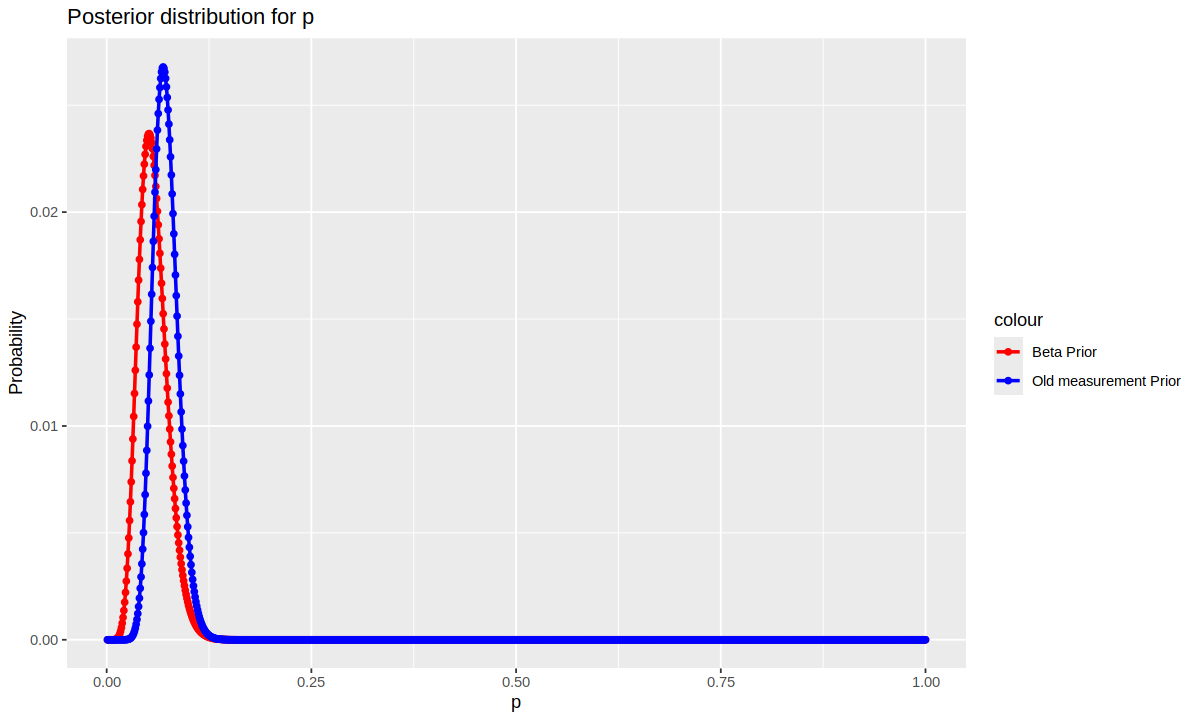

In [ ]:
posterior <- function(prior_values, r, n, p) {
  normalization <- sum(prior_values * dbinom(r, n, p))

  return(prior_values * dbinom(r, n, p) / normalization)
}

post_beta_values_2 <- post_beta(y, n, c(1, 10), p)
post_values_2 <- posterior(post_beta_values, y, n, p)

ggplot(data = data.frame(p, post_beta_values_2, post_values_2), aes(x = p)) +
  geom_point(aes(y = post_beta_values_2, color = "Beta Prior"), size = 1.5) +
  geom_line(aes(y = post_beta_values_2, color = "Beta Prior"), linewidth = 1) +
  geom_point(aes(y = post_values_2, color = "Old measurement Prior"),
             size = 1.5) +
  geom_line(aes(y = post_values_2, color = "Old measurement Prior"),
            linewidth = 1) +
  labs(title = "Posterior distribution for p",
       x = "p",
       y = "Probability") +
  scale_color_manual(values = c("red", "blue"),
                     labels = c("Beta Prior", "Old measurement Prior"))

(g) find the bayesian estimator for p, the posterior mean and variance, and a 95% credible interval

In [ ]:
p_mean <- weighted.mean(p, post_beta_values_2)
p_median <- weighted.median(p, post_beta_values_2)
p_variance <- weighted.var(p, post_beta_values_2)

cred_int <- c_int(post_beta_values_2, 0.95, p)

cat("Beta prior \n\n")
cat("Mean:", p_mean, "\n")
cat("Median:", p_median, "\n")
cat("Variance:", p_variance, "\n")
cat("95% Credibility Interval:", "(", cred_int[1], ",", cred_int[2], ")\n")
cat("\nIn general, the mean is taken as the bayesian estimator:", p_mean, "\n")
cat("\n##################################################\n\n")

p_mean <- weighted.mean(p, post_values_2)
p_median <- weighted.median(p, post_values_2)
p_variance <- weighted.var(p, post_values_2)

cred_int <- c_int(post_values_2, 0.95, p)

cat("Old measurement prior \n\n")
cat("Mean:", p_mean, "\n")
cat("Median:", p_median, "\n")
cat("Variance:", p_variance, "\n")
cat("95% Credibility Interval:", "(", cred_int[1], ",", cred_int[2], ")\n")
cat("\nIn general, the mean is taken as the bayesian estimator:", p_mean, "\n")

Beta prior 

Mean: 0.05681818 
Median: 0.0545 
Variance: 0.0003079137 
95% Credibility Interval: ( 0.029 , 0.096 )

In general, the mean is taken as the bayesian estimator: 0.05681818 

##################################################

Old measurement prior 

Mean: 0.07191781 
Median: 0.0705 
Variance: 0.0002321979 
95% Credibility Interval: ( 0.046 , 0.105 )

In general, the mean is taken as the bayesian estimator: 0.07191781 


(h) test the hypotesis: $H_0 \rightarrow p = 0.1 \; \text{versus} \; H_1 \rightarrow p \neq 0.1$ at 5% level of significance with both the frequentist and bayesian approach

In [ ]:
p0 <- 0.1

z <- (frequentist_estimator - p0) / sqrt(p0 * (1 - p0) / n)
p_value <- 2 * (1 - pnorm(abs(z)))

if (p_value < 0.05) {
  cat("The p-value is", p_value * 100, "%, which is less than the 5% threshold.", # nolinter
      "\nThus, we can reject the null hypothesis based on the frequentist analysis.\n") # nolinter
} else {
  cat("The p-value is", p_value * 100, "%, which is more than the 5% threshold.", # nolinter
      "\nThus, we cannot reject the null hypothesis based on the frequentist analysis.\n") # nolinter
}

The p-value is 5.162503 %, which is more than the 5% threshold. 
Thus, we cannot reject the null hypothesis based on the frequentist analysis.


In [ ]:
alpha <- 1
beta <- 10

alpha_post <- alpha + y
beta_post <- beta + (n - y)

lower_bound <- 0.090
upper_bound <- 0.100
post_prob <- pbeta(upper_bound, alpha_post, beta_post) -
  pbeta(lower_bound, alpha_post, beta_post)

cat("Beta prior \n\n")
if (post_prob < 0.05) {
  cat("The posterior probability is", post_prob * 100, "%, which is less than the 5% threshold.", # nolinter
      "\nThus, we can reject the null hypothesis based on the Bayesian analysis.\n") # nolinter
} else {
  cat("The posterior probability is", post_prob * 100, "%, which is more than the 5% threshold.", # nolinter
      "\nThus, we cannot reject the null hypothesis based on the Bayesian analysis.\n") # nolinter
}

cat("\n##################################################\n\n")

alpha <- alpha_post_1
beta <- beta_post_1

alpha_post <- alpha + y
beta_post <- beta + (n - y)

lower_bound <- 0.090
upper_bound <- 0.100
post_prob <- pbeta(upper_bound, alpha_post, beta_post) -
  pbeta(lower_bound, alpha_post, beta_post)

cat("Old measurement prior \n\n")
if (post_prob < 0.05) {
  cat("The posterior probability is", post_prob * 100, "%, which is less than the 5% threshold.", # nolinter
      "\nThus, we can reject the null hypothesis based on the Bayesian analysis.\n") # nolinter
} else {
  cat("The posterior probability is", post_prob * 100, "%, which is more than the 5% threshold.", # nolinter
      "\nThus, we cannot reject the null hypothesis based on the Bayesian analysis.\n") # nolinter
}

Beta prior 



The posterior probability is 2.599854 %, which is less than the 5% threshold. 
Thus, we can reject the null hypothesis based on the Bayesian analysis.

##################################################

Old measurement prior 

The posterior probability is 7.821717 %, which is more than the 5% threshold. 
Thus, we cannot reject the null hypothesis based on the Bayesian analysis.


# Exercise 4 

Aanalyze the data of Exercise 3 and solve points (b) and (c) using a Markov Chain Monte Carlo using **stan**.

In [5]:
data_list <- list(
  n = 116,
  y = 11
)

In [2]:
model_string_bacter <- "data {
  int<lower=0> n;  // Total number of samples
  int<lower=0> y;  // Number of samples with high bacter X level
}

parameters {
  real<lower=0, upper=1> p;  // Probability of high bacter X level
}

model {
  p ~ beta(1, 10);  // Beta(1, 10) prior for p
  y ~ binomial(n, p);  // Likelihood function
}"

writeLines(model_string_bacter, "model_bacter.stan")

In [3]:
bacter_model <- cmdstan_model("model_bacter.stan")

In [6]:
fit <- bacter_model$sample(
  data = data_list,
  seed = 123,
  chains = 4,
  parallel_chains = 4,
  refresh = 500,
  iter_warmup = 1000,
  iter_sampling = 1000
)

fit$summary()

Running MCMC with 4 parallel chains...

Chain 1 Iteration:    1 / 2000 [  0%]  (Warmup) 
Chain 1 Iteration:  500 / 2000 [ 25%]  (Warmup) 
Chain 1 Iteration: 1000 / 2000 [ 50%]  (Warmup) 
Chain 1 Iteration: 1001 / 2000 [ 50%]  (Sampling) 
Chain 1 Iteration: 1500 / 2000 [ 75%]  (Sampling) 
Chain 1 Iteration: 2000 / 2000 [100%]  (Sampling) 
Chain 2 Iteration:    1 / 2000 [  0%]  (Warmup) 
Chain 2 Iteration:  500 / 2000 [ 25%]  (Warmup) 
Chain 2 Iteration: 1000 / 2000 [ 50%]  (Warmup) 
Chain 2 Iteration: 1001 / 2000 [ 50%]  (Sampling) 
Chain 2 Iteration: 1500 / 2000 [ 75%]  (Sampling) 
Chain 2 Iteration: 2000 / 2000 [100%]  (Sampling) 
Chain 3 Iteration:    1 / 2000 [  0%]  (Warmup) 
Chain 3 Iteration:  500 / 2000 [ 25%]  (Warmup) 
Chain 3 Iteration: 1000 / 2000 [ 50%]  (Warmup) 
Chain 3 Iteration: 1001 / 2000 [ 50%]  (Sampling) 
Chain 3 Iteration: 1500 / 2000 [ 75%]  (Sampling) 
Chain 3 Iteration: 2000 / 2000 [100%]  (Sampling) 
Chain 4 Iteration:    1 / 2000 [  0%]  (Warmup) 
Chain 4 Ite

variable,mean,median,sd,mad,q5,q95,rhat,ess_bulk,ess_tail
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
lp__,-40.23599168,-39.9614000,0.7134981,0.32172420,-41.73168000,-39.727500,1.002595,2010.351,1903.723
p,0.09451674,0.0919741,0.0260264,0.02603594,0.05636616,0.141187,1.001038,1555.458,1440.196


In [7]:
posterior_samples <- fit$draws(variables = "p")

p_mean <- mean(posterior_samples)
p_median <- median(posterior_samples)
p_variance <- var(posterior_samples)
cred_interval <- quantile(posterior_samples, probs = c(0.025, 0.975))

cat("Mean:", p_mean, "\n")
cat("Median:", p_median, "\n")
cat("Variance:", p_variance, "\n")
cat("95% Credibility Interval:", cred_interval, "\n")

Mean: 0.09451674 
Median: 0.0919741 
Variance: 0.0006773734 
95% Credibility Interval: 0.05057346 0.152571 


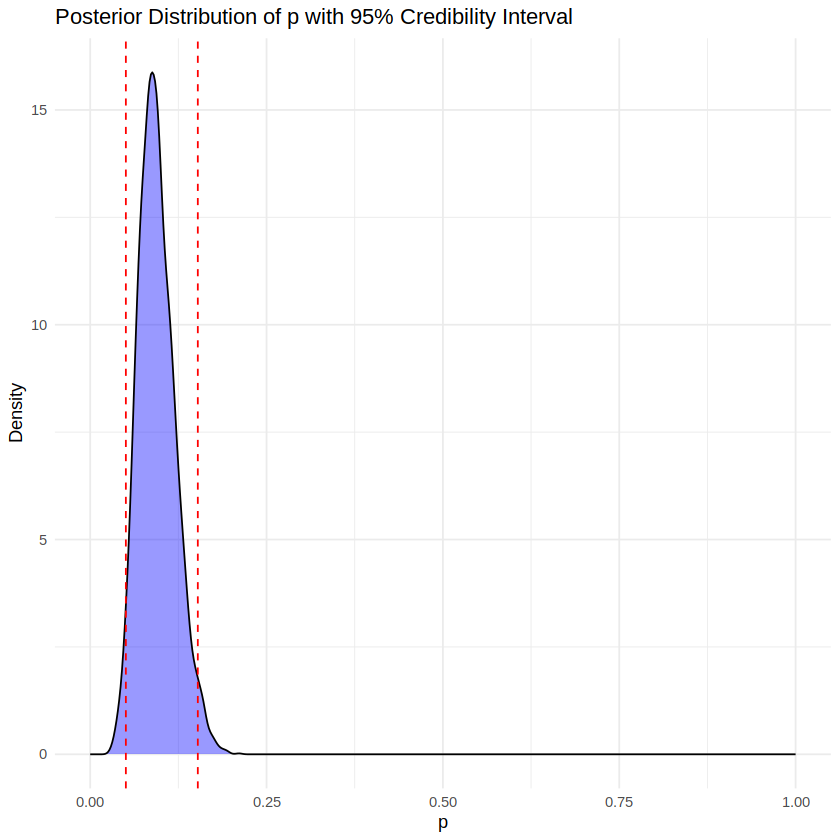

In [12]:
p_post_values <- as.vector(as.matrix(posterior_samples))

ggplot() +
  geom_density(data = data.frame(p = p_post_values),
               aes(x = p), fill = "blue", alpha = 0.4) +
  geom_vline(xintercept = cred_interval[1],
             linetype = "dashed", color = "red") +
  geom_vline(xintercept = cred_interval[2],
             linetype = "dashed", color = "red") +
  labs(title = "Posterior Distribution of p with 95% Credibility Interval", # nolinter
       x = "p", y = "Density") +
  xlim(0, 1) +
  theme_minimal()